# Introduction to TensorFlow and Keras

In this notebook we define a simple network architechture for taking in 1D input. Here we are going to train a network to mimic the behaviour of an arbitrary function.

Once more this notebook is heavily inspired by https://machine-learning-for-physicists.org and is relased under the same Creative Commons License.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras


import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

print("tf.__version__",tf.__version__)

tf.__version__ 2.10.0


### Define our network
We will define a network with one input and one output and two hidden layers.
- First hidden layer has 1 input and 20 neurons with sigmoid activation functions
- Second hidden layer takes 20 inputs (from the first hidden layer) and has 10 neurons with sigmoid activation functions.
- Output layer is a single neuron with linear activation function.

In [9]:
model = keras.Sequential([
    keras.layers.Dense(20,input_shape=(1,),activation="sigmoid"),
    keras.layers.Dense(10,activation='sigmoid'),
    keras.layers.Dense(1,activation='linear')
])

Having defined our network the next step is to compile it, specifing which loss function and which optimiser we want to use. Here we will use the 'adam' optimiser which is adaptive and much more perfromant than the standard gradient descent algorithm.

In [10]:
model.compile(loss='mean_squared_error',optimizer='adam')

### Now let's look at our network
There are lots of built in functions to understand the network structure here we will look at a couple.
` model.summary()` - This prints a string summary of the network.


In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                40        
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


There are a few things to note here:
* Each layer has it's own name that is autogenerated (dense_1, dense_2, etc.)
* The first dimension of the output of each layer is `None` this is because that dimension is variable and corresponds to the batchsize
* Can you work out why each layer has the number of parameters that it does?

If you have some extra packages installed (pydot + graphviz) you can also get a pretty plot of the network using the `kera.util.plot_model` function

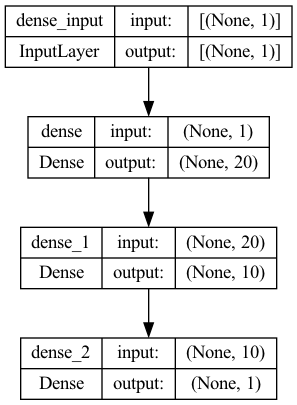

In [7]:
#keras.utils.plot_model(model,show_shapes=True)

Now lets define our target function

In [4]:
#A wave packet target function
def target_func(y):
    return( np.sin(y)/(1+y**2) ) # a wave packet...

Rather than using `model.fit` we will use `model.train_on_batch` to illustrate the steps in running the training. Repeatedly running the cell below will have the same effect as increasing the number of batches used in the training.

In [5]:

nbatch = 2000  #Number of batches
batchsize = 100 #Samples per batch
costs=np.zeros(nbatch) #Output array for the costs

#Loop over the batches, get batchsize samples and train the network
for i in range(nbatch):
    x=np.random.uniform(low=-10.0,high=+10.0,size=[batchsize,1]) #Generate batchsize random numbers
    y=target_func(x) #Evaluate the function for each random number
    costs[i]=model.train_on_batch(x,y)  #Train the model on this batch of data
                        

2022-10-19 15:21:43.313559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-19 15:21:43.313797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Text(0, 0.5, 'Cost')

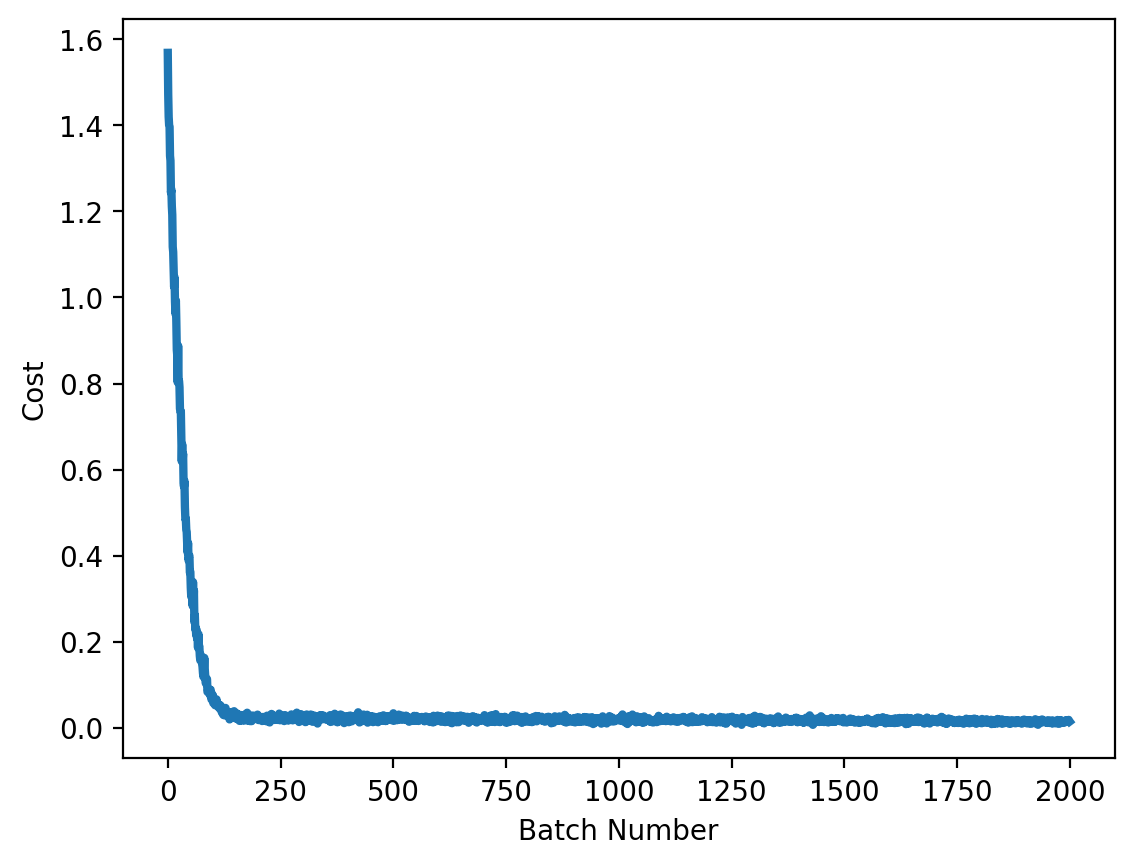

In [6]:
#Here we plot the cost vs batch number 
fig, ax = plt.subplots()  #I like to make plots using this silly fig,ax method but plot how you like
step=np.arange(nbatch)  
ax.plot(step,costs,linewidth=3)
ax.set_xlabel("Batch Number")
ax.set_ylabel("Cost")

2022-10-19 15:21:56.214386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


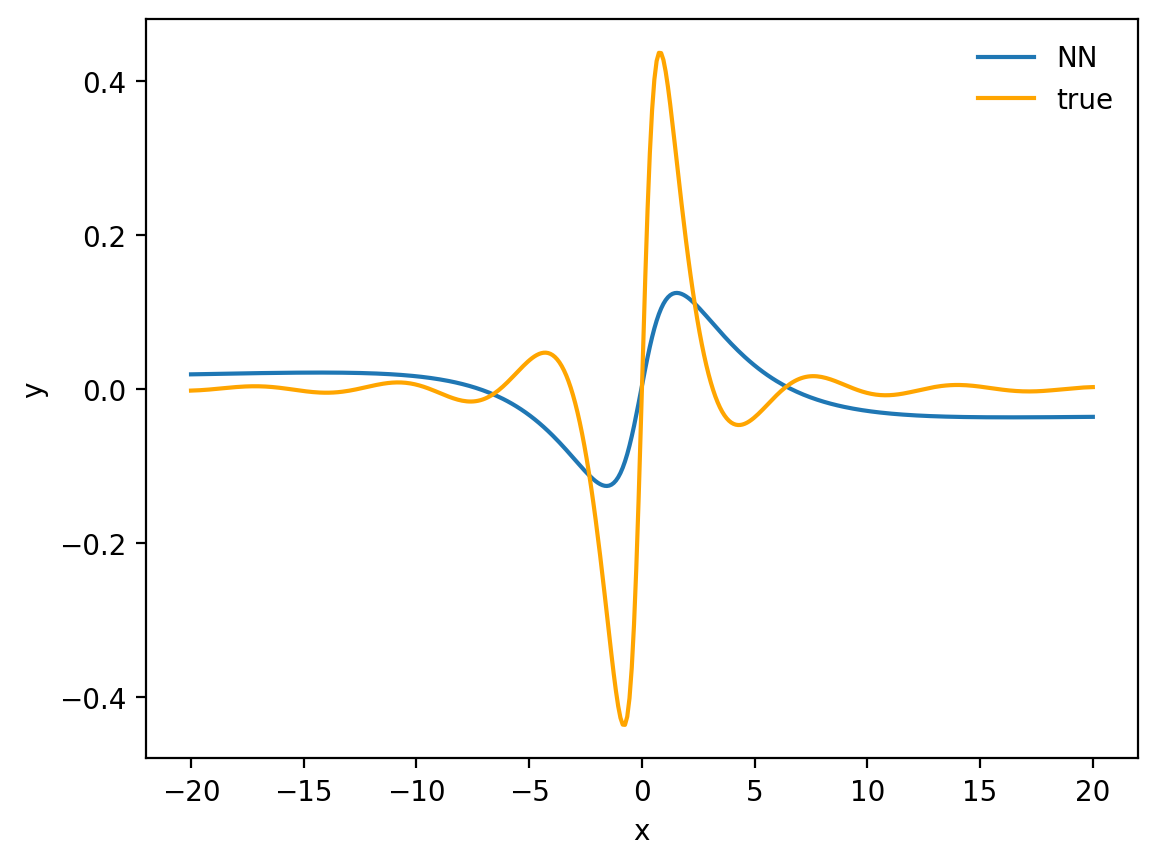

In [7]:
# get the output on a 1D grid of points:
N=400 # number of points
y_in=np.zeros([N,1]) # prepare correct shape for network, here N becomes the batch size
y_in[:,0]=np.linspace(-20.0,20.0,N) # fill with interval
y_out=model.predict_on_batch(y_in) # apply the network to this set of points!

# plot it!
fig, ax = plt.subplots() 
ax.plot(y_in,y_out,label="NN")
ax.plot(y_in,target_func(y_in),color="orange",label="true")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

## Further work

### Exercise 1: Make a better network?
Can you improve the network model and make a better fit to the inpout function? You could try changing the number of neurons per layer, the number of layers, or the activation functions for each layer. What metric would you use for determining if the network was better?

### Exercise 2: Try other functions
Are some functions easier to model than others? What types of functions are the most difficult to model?